# Obligatorio - Machine Learning
# 1. Importación de librerías
# 2. Preprocesamiento de datos
# 3. Análisis exploratorio
# 4. Entrenamiento de modelos
# 5. Evaluación de modelos
# 6. Exportación de predicciones

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats.mstats import winsorize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Wandb Login
import wandb

df_train = pd.read_csv('./dataset/train.csv')
df_test = pd.read_csv('./dataset/test.csv')

# Funciones Auxiliares

In [103]:
# Paso 1: Rellenar valores faltantes
def clean_data(df):
    # Completar valores faltantes
    df['Year'] = df['Year'].fillna(df['Year'].median())  # Completar con la mediana
    df['Publisher'] = df['Publisher'].fillna('Unknown')  # Completar con "Unknown"

    # Eliminar columnas irrelevantes
    if 'Summary' in df.columns:
        df = df.drop(columns=['Summary'])

    return df

# Paso 2: Convertir columnas numéricas con valores inconsistentes
def convert_to_numeric(value):
    """
    Convierte valores como '1.2K' en valores numéricos.
    """
    value_str = str(value)
    if 'K' in value_str:
        return float(value_str.replace('K', '')) * 1000
    try:
        return float(value_str)
    except ValueError:
        return 0.0

# Paso 3: Manejar outliers
def handle_outliers(df, columns):
    """
    Aplica winsorización para manejar valores extremos en las columnas especificadas.
    """
    for col in columns:
        df[col] = winsorize(df[col], limits=[0.01, 0.01])  # Recorta 1% inferior y superior
    return df

# Paso 4: Codificar variables categóricas
def encode_categorical(df, categorical_columns):
    label_encoder = LabelEncoder()
    for col in categorical_columns:
        if col in df.columns:
            df[col] = label_encoder.fit_transform(df[col])
    return df

# Paso 5: Escalar columnas numéricas
def scale_numerical(df, numerical_columns):
    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    return df

# Paso 6: Rellenar valores faltantes en `Genre` usando `Summary`
def fill_missing_genres(df):
    """
    Rellena los valores faltantes de la columna `Genre` basándose en la columna `Summary`.
    Utiliza un modelo de clasificación de texto.
    """
    # Separar filas con y sin `Genre`
    df_with_genre = df[df['Genre'].notnull()]
    df_missing_genre = df[df['Genre'].isnull()]

    if len(df_missing_genre) > 0:
        # Convertir valores categóricos de `Genre` a números
        label_encoder = LabelEncoder()
        df_with_genre['Genre'] = label_encoder.fit_transform(df_with_genre['Genre'])

        # Modelo de clasificación de texto
        text_clf = Pipeline([
            ('tfidf', TfidfVectorizer(stop_words='english', max_features=1000)),
            ('clf', LogisticRegression(max_iter=1000, random_state=42))
        ])

        # Entrenar el modelo con los datos disponibles
        text_clf.fit(df_with_genre['Summary'], df_with_genre['Genre'])

        # Predecir los géneros faltantes
        predicted_genres = text_clf.predict(df_missing_genre['Summary'])

        # Convertir las predicciones de vuelta a etiquetas originales
        df_missing_genre['Genre'] = label_encoder.inverse_transform(predicted_genres)

        # Combinar las filas con `Genre` y las predichas
        df = pd.concat([df_with_genre, df_missing_genre])

    return df

# Paso 7: Crear nuevas columnas derivadas
def create_new_columns(df):
    """
    Crea nuevas columnas derivadas basadas en la información existente.
    """
    df['Game_Age'] = 2024 - df['Year']
    
    # Ratios regionales
    df['NorthAmerica_Global_Ratio'] = df['North America'] / df['Global']
    df['Europe_Global_Ratio'] = df['Europe'] / df['Global']
    df['Japan_Global_Ratio'] = df['Japan'] / df['Global']
    df['RestOfWorld_Global_Ratio'] = df['Rest of World'] / df['Global']

    return df


# Preprocesamiento de los datos

In [104]:
import wandb

def preprocess_data(df):
    """
    Realiza el preprocesamiento completo de los datos, incluyendo limpieza, manejo de outliers,
    codificación de variables categóricas, creación de columnas derivadas y escalado, excluyendo
    columnas que se eliminarán al final.
    """
    # Eliminar columnas irrelevantes al inicio
    columns_to_drop_early = ['id', 'Publisher','Wishlist', 'Number of Reviews']
    df = df.drop(columns=[col for col in columns_to_drop_early if col in df.columns])

    # Limpiar datos
    df = clean_data(df)

    # Rellenar valores faltantes en `Genre` usando `Summary` (si aún existen)
    if 'Summary' in df.columns and 'Genre' in df.columns:
        df = fill_missing_genres(df)

    # Convertir columnas numéricas con valores inconsistentes
    columns_to_convert = ['Europe', 'Japan', 'Rest of World', 'North America', 'Global']
    for col in columns_to_convert:
        if col in df.columns:
            df[col] = df[col].apply(convert_to_numeric)

    # Manejar outliers
    outlier_columns = ['Global']
    df = handle_outliers(df, outlier_columns)

    # Codificar variables categóricas
    categorical_columns = ['Game Title', 'Platform', 'Genre']
    df = encode_categorical(df, categorical_columns)

    # Crear nuevas columnas derivadas
    if 'Global' in df.columns:
        df = create_new_columns(df)

    # Escalar columnas numéricas
    numerical_columns = ['Global', 'Game_Age', 'Europe_Global_Ratio', 
                         'Japan_Global_Ratio', 'NorthAmerica_Global_Ratio', 
                         'RestOfWorld_Global_Ratio']
    df = scale_numerical(df, numerical_columns)

    # Eliminar columnas originales usadas para ratios
    columns_to_drop = ['North America', 'Europe', 'Japan', 'Rest of World']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    return df

# Aplicar el preprocesamiento actualizado
df_train = preprocess_data(df_train)
df_test = preprocess_data(df_test)

# Verificar el resultado
print("Datos preprocesados (train):")
print(df_train.head())

Datos preprocesados con géneros rellenados y nuevas columnas (train):
   id    Year  Publisher    Global  Number of Reviews  Wishlist  Platform  \
0   1  2007.0        500 -0.340005           0.839035  1.359185         0   
1   2  2007.0        500 -0.340005           2.496069 -0.326198         0   
2   3  2007.0        500 -0.340005           0.878488  1.385937         0   
3   4  1987.0        337  4.952858           2.658265  0.786689        10   
4   5  2007.0        500 -0.340005           2.719637  3.360243         0   

   Genre    Rating  Game_Age  NorthAmerica_Global_Ratio  Europe_Global_Ratio  \
0     11  7.345609 -0.220206                   0.125542            -0.340306   
1     13  6.511195 -0.220206                   0.125542            -0.340306   
2     13  6.651093 -0.220206                   0.125542            -0.340306   
3      1  7.900000  3.204727                   0.210322            -0.354835   
4      1  7.152074 -0.220206                   0.125542            

Importancia de características basada en correlación:
                           Feature        Score
3                           Global  6405.992197
12        RestOfWorld_Global_Ratio   583.919107
9        NorthAmerica_Global_Ratio   365.169610
7                            Genre   311.619155
11              Japan_Global_Ratio   297.402654
10             Europe_Global_Ratio   180.030086
6                         Platform    97.097748
13          Reviews_Wishlist_Ratio    83.682834
4                Number of Reviews    44.871705
1                             Year    19.721526
8                         Game_Age    19.721526
0                               id    15.409472
5                         Wishlist     9.157735
14  Publisher_Platform_Interaction     1.847696
2                        Publisher     0.734464


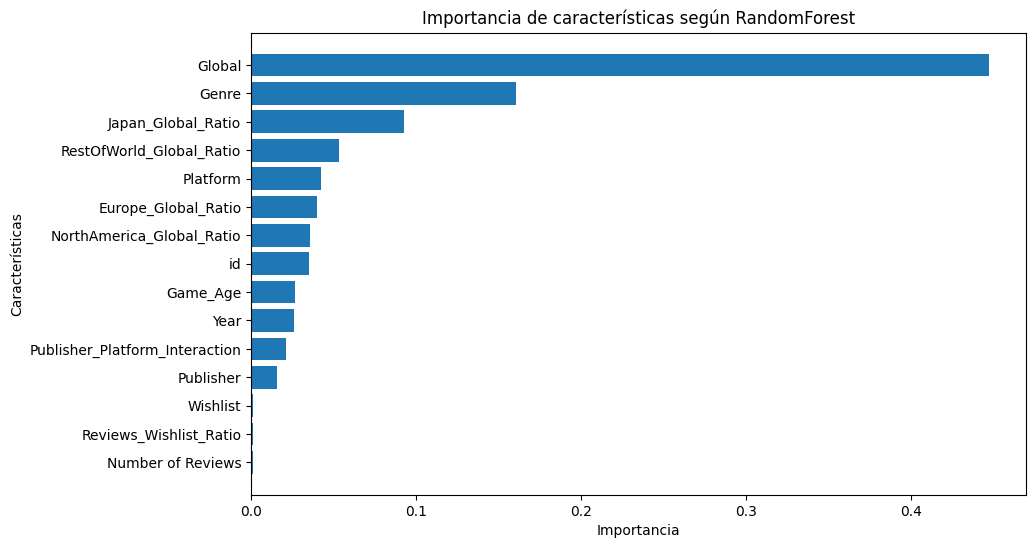

Importancia de características basada en RandomForest:
                           Feature  Importance
3                           Global    0.447378
7                            Genre    0.160363
11              Japan_Global_Ratio    0.092788
12        RestOfWorld_Global_Ratio    0.052983
6                         Platform    0.042426
10             Europe_Global_Ratio    0.039963
9        NorthAmerica_Global_Ratio    0.035829
0                               id    0.035300
8                         Game_Age    0.026853
1                             Year    0.025802
14  Publisher_Platform_Interaction    0.021382
2                        Publisher    0.015592
5                         Wishlist    0.001334
13          Reviews_Wishlist_Ratio    0.001069
4                Number of Reviews    0.000940
Características seleccionadas (10 mejores): Index(['Year', 'Global', 'Number of Reviews', 'Platform', 'Genre',
       'NorthAmerica_Global_Ratio', 'Europe_Global_Ratio',
       'Japan_Global_Ra

In [105]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Función para evaluar correlación con la variable objetivo (para regresión)
def evaluate_feature_correlation(X, y):
    """
    Evalúa la correlación de cada característica con la variable objetivo.
    Devuelve un DataFrame con las puntuaciones.
    """
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X, y)
    scores = selector.scores_

    # Crear un DataFrame con las puntuaciones
    feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
    feature_scores = feature_scores.sort_values(by='Score', ascending=False)

    print("Importancia de características basada en correlación:")
    print(feature_scores)
    return feature_scores

# Función para evaluar la importancia de características usando un modelo
def evaluate_feature_importance_model(X, y):
    """
    Evalúa la importancia de características utilizando un RandomForestRegressor.
    Devuelve un DataFrame con las importancias.
    """
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_

    # Crear un DataFrame con las importancias
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Visualizar la importancia de características
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['Feature'], feature_importances['Importance'])
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.title("Importancia de características según RandomForest")
    plt.gca().invert_yaxis()
    plt.show()

    print("Importancia de características basada en RandomForest:")
    print(feature_importances)
    return feature_importances

# Selección de las características más relevantes
def select_top_features(X, y, k=10):
    """
    Selecciona las k características más relevantes utilizando SelectKBest.
    """
    selector = SelectKBest(score_func=f_regression, k=k)
    X_selected = selector.fit_transform(X, y)

    # Obtener las columnas seleccionadas
    selected_columns = X.columns[selector.get_support()]
    print(f"Características seleccionadas ({k} mejores): {selected_columns}")
    return X_selected, selected_columns

# Para df_train (como ya tienes)
X_train = df_train.drop(columns=['Rating'])  # Variables predictoras
y_train = df_train['Rating']  # Variable objetivo

# Evaluar y seleccionar características en df_train
correlation_scores = evaluate_feature_correlation(X_train, y_train)
importance_scores = evaluate_feature_importance_model(X_train, y_train)
X_train_selected, selected_columns = select_top_features(X_train, y_train, k=10)

# Actualizar el dataset de entrenamiento
df_train_selected = pd.DataFrame(X_train_selected, columns=selected_columns)
df_train_selected['Rating'] = y_train  # Añadir la columna objetivo para usar en el modelo

# Aplicar la misma selección de características al conjunto de prueba**
if 'Rating' in df_test.columns:
    X_test = df_test.drop(columns=['Rating'])  # Variables predictoras en el conjunto de prueba
    y_test = df_test['Rating']  # Variable objetivo en el conjunto de prueba
else:
    X_test = df_test
    y_test = None

# Seleccionar las mismas características en df_test usando `selected_columns`
X_test_selected = X_test[selected_columns]

# Actualizar el dataset de prueba
df_test_selected = pd.DataFrame(X_test_selected, columns=selected_columns)
if y_test is not None:
    df_test_selected['Rating'] = y_test  # Solo si `Rating` está disponible

In [ ]:
def preprocess_data_optimized(df):

    # Eliminar columnas menos relevantes
    columns_to_drop = ['id', 'Publisher_Platform_Interaction', 'Publisher', 'Wishlist', 
                       'Number of Reviews', 'Reviews_Wishlist_Ratio']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    return df

# Aplicar el preprocesamiento optimizado
df_train = preprocess_data_optimized(df_train)
df_test = preprocess_data_optimized(df_test)

# Verificar el resultado
print("Datos preprocesados optimizados (train):")
print(df_train.head())

In [ ]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Función para evaluar correlación con la variable objetivo (para regresión)
def evaluate_feature_correlation(X, y):
    """
    Evalúa la correlación de cada característica con la variable objetivo.
    Devuelve un DataFrame con las puntuaciones.
    """
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X, y)
    scores = selector.scores_

    # Crear un DataFrame con las puntuaciones
    feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
    feature_scores = feature_scores.sort_values(by='Score', ascending=False)

    print("Importancia de características basada en correlación:")
    print(feature_scores)
    return feature_scores

# Función para evaluar la importancia de características usando un modelo
def evaluate_feature_importance_model(X, y):
    """
    Evalúa la importancia de características utilizando un RandomForestRegressor.
    Devuelve un DataFrame con las importancias.
    """
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_

    # Crear un DataFrame con las importancias
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Visualizar la importancia de características
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['Feature'], feature_importances['Importance'])
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.title("Importancia de características según RandomForest")
    plt.gca().invert_yaxis()
    plt.show()

    print("Importancia de características basada en RandomForest:")
    print(feature_importances)
    return feature_importances

# Selección de las características más relevantes
def select_top_features(X, y, k=10):
    """
    Selecciona las k características más relevantes utilizando SelectKBest.
    """
    selector = SelectKBest(score_func=f_regression, k=k)
    X_selected = selector.fit_transform(X, y)

    # Obtener las columnas seleccionadas
    selected_columns = X.columns[selector.get_support()]
    print(f"Características seleccionadas ({k} mejores): {selected_columns}")
    return X_selected, selected_columns

# Para df_train (como ya tienes)
X_train = df_train.drop(columns=['Rating'])  # Variables predictoras
y_train = df_train['Rating']  # Variable objetivo

# Evaluar y seleccionar características en df_train
correlation_scores = evaluate_feature_correlation(X_train, y_train)
importance_scores = evaluate_feature_importance_model(X_train, y_train)
X_train_selected, selected_columns = select_top_features(X_train, y_train, k=10)

# Actualizar el dataset de entrenamiento
df_train_selected = pd.DataFrame(X_train_selected, columns=selected_columns)
df_train_selected['Rating'] = y_train  # Añadir la columna objetivo para usar en el modelo

# Aplicar la misma selección de características al conjunto de prueba
# Como no tiene la columna `Rating`, simplemente seleccionamos las columnas relevantes
X_test = df_test[selected_columns]

# Actualizar el dataset de prueba
df_test_selected = pd.DataFrame(X_test, columns=selected_columns)

# df_test_selected ahora contiene solo las características seleccionadas para hacer predicciones
print("Características seleccionadas en el conjunto de prueba:")
print(df_test_selected.head())

# Modelado y Evaluacion de los modelos

In [ ]:
# Dividir los datos para entrenamiento y prueba

# Entrenamiento: X_train y y_train
X_train = df_train_selected.drop(columns=['Rating'])  # Variables predictoras del conjunto de entrenamiento
y_train = df_train_selected['Rating']  # Variable objetivo del conjunto de entrenamiento

# Prueba: X_test (sin Rating)
X_test = df_test_selected  # df_test seleccionado y procesado ya no incluye la columna Rating

Regresion Lineal

In [ ]:
import wandb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Inicializar proyecto de Weights and Biases
wandb.init(project="Obligatorio2024ML", name="Evaluación_Regresión_Lineal")

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hiperparámetros para optimizar
param_grid_lr = {
    'fit_intercept': [True, False]  # Ajustar o no el intercepto
}

# Modelo base LinearRegression
lr_model = LinearRegression()

# Optimización con GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    cv=5,  # Validación cruzada con 5 particiones
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Entrenar el modelo con los datos de entrenamiento
grid_search_lr.fit(X_train_scaled, y_train)

# Mejor modelo encontrado
best_lr_model = grid_search_lr.best_estimator_
print("Mejores parámetros para Regresión Lineal:", grid_search_lr.best_params_)

# Predicciones con el modelo optimizado
y_pred = best_lr_model.predict(X_test_scaled)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModelo: Regresión Lineal Optimizada")
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# Validación cruzada con los datos de entrenamiento
cv_scores = cross_val_score(best_lr_model, X_train_scaled, y_train, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("\nValidación cruzada para Regresión Lineal:")
print(f"R² promedio en validación cruzada: {cv_mean:.4f}")
print(f"Desviación estándar de R²: {cv_std:.4f}")

# Registrar todas las métricas y parámetros en un solo wandb.log
wandb.log({
    "Mejor Error Cuadrático Medio Negativo (CV)": -grid_search_lr.best_score_,
    "Error Cuadrático Medio (MSE) de prueba": mse,
    "Raíz del Error Cuadrático Medio (RMSE) de prueba": rmse,
    "Coeficiente de Determinación (R²) de prueba": r2,
    "R² promedio en validación cruzada": cv_mean,
    "Desviación estándar de R² en validación cruzada": cv_std
})

# Crear una tabla con los resultados
results_table = pd.DataFrame({
    "Error Cuadrático Medio (MSE)": [mse],
    "Raíz del Error Cuadrático Medio (RMSE)": [rmse],
    "Coeficiente de Determinación (R²)": [r2],
    "R² promedio (validación cruzada)": [cv_mean],
    "R² (Desviación estándar - validación cruzada)": [cv_std]
})

# Registrar la tabla en WandB
wandb.log({"Tabla de Resultados": wandb.Table(dataframe=results_table)})

print("\nResultados finales:")
print(results_table)

# Finalizar WandB
wandb.finish()


Arboles de decision

In [ ]:
import wandb
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Inicializar proyecto de Weights and Biases
wandb.init(project="Obligatorio2024ML", name="Evaluación_Árbol_Decisión")

# Hiperparámetros para optimizar
param_grid_tree = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 50, 100],
    'min_impurity_decrease': [0.0, 0.01, 0.1]
}

# Optimización con GridSearchCV
grid_search_tree = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid_tree,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Entrenar el modelo
grid_search_tree.fit(X_train, y_train)

# Mejor modelo encontrado
best_tree_model = grid_search_tree.best_estimator_
print("Mejores parámetros para Árbol de Decisión:", grid_search_tree.best_params_)

# Predicciones
y_pred = best_tree_model.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModelo: Árbol de Decisión Optimizado")
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# Validación cruzada con los datos de entrenamiento
cv_scores = cross_val_score(best_tree_model, X_train, y_train, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("\nValidación cruzada para Árbol de Decisión:")
print(f"R² promedio en validación cruzada: {cv_mean:.4f}")
print(f"Desviación estándar de R²: {cv_std:.4f}")

# Registrar todas las métricas y parámetros en un solo `wandb.log`
best_params = grid_search_tree.best_params_
wandb.log({
    "Mejor Error Cuadrático Medio Negativo (CV)": -grid_search_tree.best_score_,
    "Error Cuadrático Medio (MSE) de prueba": mse,
    "Raíz del Error Cuadrático Medio (RMSE) de prueba": rmse,
    "Coeficiente de Determinación (R²) de prueba": r2,
    "R² promedio en validación cruzada": cv_mean,
    "Desviación estándar de R² en validación cruzada": cv_std
})

# Crear una tabla con los resultados
results_table = pd.DataFrame({
    "Error Cuadrático Medio (MSE)": [mse],
    "Raíz del Error Cuadrático Medio (RMSE)": [rmse],
    "Coeficiente de Determinación (R²)": [r2],
    "R² promedio (validación cruzada)": [cv_mean],
    "R² (Desviación estándar - validación cruzada)": [cv_std]
})

# Registrar la tabla en WandB
wandb.log({"Tabla de Resultados": wandb.Table(dataframe=results_table)})

print("\nResultados finales:")
print(results_table)

# Finalizar WandB
wandb.finish()


Random Forest

In [ ]:
import wandb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Inicializar proyecto de Weights and Biases
wandb.init(project="Obligatorio2024ML", name="Evaluación_Random_Forest")

# Hiperparámetros para optimizar
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Optimización con GridSearchCV
grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_rf,
    cv=5,  # Validación cruzada con 5 particiones
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1  # Usa todos los núcleos disponibles
)

# Entrenar el modelo con los datos de entrenamiento
grid_search_rf.fit(X_train, y_train)

# Mejor modelo encontrado
optimized_rf_model = grid_search_rf.best_estimator_
print("Mejores parámetros para Random Forest:", grid_search_rf.best_params_)

# Predicciones con el mejor modelo
y_pred = optimized_rf_model.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModelo: Random Forest Optimizado")
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# Validación cruzada para calcular métricas adicionales
cv_scores = cross_val_score(optimized_rf_model, X_train, y_train, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("\nValidación cruzada para Random Forest:")
print(f"R² promedio en validación cruzada: {cv_mean:.4f}")
print(f"Desviación estándar de R²: {cv_std:.4f}")

# Registrar todas las métricas y parámetros en un solo `wandb.log`
wandb.log({
    "Mejor Error Cuadrático Medio Negativo (CV)": -grid_search_rf.best_score_,
    "Error Cuadrático Medio (MSE) de prueba": mse,
    "Raíz del Error Cuadrático Medio (RMSE) de prueba": rmse,
    "Coeficiente de Determinación (R²) de prueba": r2,
    "R² promedio en validación cruzada": cv_mean,
    "Desviación estándar de R² en validación cruzada": cv_std
})

# Crear una tabla con los resultados
results_table = pd.DataFrame({
    "Error Cuadrático Medio (MSE)": [mse],
    "Raíz del Error Cuadrático Medio (RMSE)": [rmse],
    "Coeficiente de Determinación (R²)": [r2],
    "R² promedio (validación cruzada)": [cv_mean],
    "R² (Desviación estándar - validación cruzada)": [cv_std]
})

# Registrar la tabla en WandB
wandb.log({"Tabla de Resultados": wandb.Table(dataframe=results_table)})

print("\nResultados finales:")
print(results_table)

# Finalizar WandB
wandb.finish()

Gradient Boosting

In [ ]:
import wandb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Inicializar proyecto de Weights and Biases
wandb.init(project="Obligatorio2024ML", name="Evaluación_Gradient_Boosting")

# Hiperparámetros para optimizar
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]  # Prueba con una fracción de los datos
}

# Optimización con GridSearchCV
grid_search_gb = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1  # Usa todos los núcleos disponibles
)

# Entrenar el modelo con los datos de entrenamiento
grid_search_gb.fit(X_train, y_train)

# Mejor modelo encontrado
best_gb_model = grid_search_gb.best_estimator_
print("Mejores parámetros para Gradient Boosting:", grid_search_gb.best_params_)

# Predicciones con el modelo optimizado
y_pred = best_gb_model.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModelo: Gradient Boosting Optimizado")
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# Validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_gb_model, X_train, y_train, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("\nValidación cruzada para Gradient Boosting:")
print(f"R² promedio en validación cruzada: {cv_mean:.4f}")
print(f"Desviación estándar de R²: {cv_std:.4f}")

# Registrar todas las métricas y parámetros en un solo `wandb.log`
wandb.log({
    "Mejor Error Cuadrático Medio Negativo (CV)": -grid_search_gb.best_score_,
    "Error Cuadrático Medio (MSE) de prueba": mse,
    "Raíz del Error Cuadrático Medio (RMSE) de prueba": rmse,
    "Coeficiente de Determinación (R²) de prueba": r2,
    "R² promedio en validación cruzada": cv_mean,
    "Desviación estándar de R² en validación cruzada": cv_std
})

# Crear una tabla con los resultados
results_table = pd.DataFrame({
    "Error Cuadrático Medio (MSE)": [mse],
    "Raíz del Error Cuadrático Medio (RMSE)": [rmse],
    "Coeficiente de Determinación (R²)": [r2],
    "R² promedio (validación cruzada)": [cv_mean],
    "R² (Desviación estándar - validación cruzada)": [cv_std]
})

# Registrar la tabla en WandB
wandb.log({"Tabla de Resultados": wandb.Table(dataframe=results_table)})

print("\nResultados finales:")
print(results_table)

# Finalizar WandB
wandb.finish()

Ada boost

In [ ]:
import wandb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Inicializar proyecto de Weights and Biases
wandb.init(project="Obligatorio2024ML", name="Evaluación_AdaBoost")

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Cambiar el estimador base a un árbol de decisión más profundo
base_estimator = DecisionTreeRegressor(random_state=42)

# Hiperparámetros para optimizar
param_grid_ada = {
    'n_estimators': [100, 200, 300],  # Número de árboles en el modelo
    'learning_rate': [0.01, 0.1],  # Tasa de aprendizaje
    'estimator__max_depth': [5, 7, 10]  # Profundidad del estimador base
}

# Optimización con GridSearchCV
grid_search_ada = GridSearchCV(
    AdaBoostRegressor(estimator=base_estimator, random_state=42),
    param_grid_ada,
    cv=5,  # Validación cruzada
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1  # Paralelización
)

# Entrenar el modelo con los datos escalados
grid_search_ada.fit(X_train_scaled, y_train)

# Mejor modelo encontrado
best_ada_model = grid_search_ada.best_estimator_
print("Mejores parámetros para AdaBoost:", grid_search_ada.best_params_)

# Predicciones con el modelo optimizado
y_pred = best_ada_model.predict(X_test_scaled)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModelo: AdaBoost Optimizado")
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# Validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_ada_model, X_train_scaled, y_train, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("\nValidación cruzada para AdaBoost:")
print(f"R² promedio en validación cruzada: {cv_mean:.4f}")
print(f"Desviación estándar de R²: {cv_std:.4f}")

# Registrar todas las métricas y parámetros en un solo `wandb.log`
wandb.log({
    "Mejor Error Cuadrático Medio Negativo (CV)": -grid_search_ada.best_score_,
    "Error Cuadrático Medio (MSE) de prueba": mse,
    "Raíz del Error Cuadrático Medio (RMSE) de prueba": rmse,
    "Coeficiente de Determinación (R²) de prueba": r2,
    "R² promedio en validación cruzada": cv_mean,
    "Desviación estándar de R² en validación cruzada": cv_std
})

# Crear una tabla con los resultados
results_table = pd.DataFrame({
    "Error Cuadrático Medio (MSE)": [mse],
    "Raíz del Error Cuadrático Medio (RMSE)": [rmse],
    "Coeficiente de Determinación (R²)": [r2],
    "R² promedio (validación cruzada)": [cv_mean],
    "R² (Desviación estándar - validación cruzada)": [cv_std]
})

# Registrar la tabla en WandB
wandb.log({"Tabla de Resultados": wandb.Table(dataframe=results_table)})

print("\nResultados finales:")
print(results_table)

# Finalizar WandB
wandb.finish()

Redes Neuronales

In [ ]:
import wandb
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Inicializar proyecto de Weights and Biases
wandb.init(project="Obligatorio2024ML", name="Evaluación_Redes_Neuronales")

# Escalar los datos (muy importante para redes neuronales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hiperparámetros inspirados en boosting
param_grid_mlp = {
    'hidden_layer_sizes': [(50, 50), (100, 50), (150, 100, 50)],  # Configuraciones de capas ocultas
    'activation': ['relu'],  # Función de activación estándar para regresión
    'solver': ['adam'],  # Algoritmo de optimización robusto
    'alpha': [0.0001, 0.001, 0.01],  # Regularización L2
    'learning_rate_init': [0.001, 0.01, 0.1],  # Tasa de aprendizaje
    'max_iter': [200],  # Número de iteraciones
    'early_stopping': [True]  # Parada temprana
}

# Optimización con GridSearchCV
grid_search_mlp = GridSearchCV(
    MLPRegressor(random_state=42),
    param_grid_mlp,
    cv=5,  # Validación cruzada con 5 folds
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1  # Paralelización
)

# Entrenar el modelo con los datos escalados
grid_search_mlp.fit(X_train_scaled, y_train)

# Mejor modelo encontrado
best_mlp_model = grid_search_mlp.best_estimator_
print("Mejores parámetros para Redes Neuronales:", grid_search_mlp.best_params_)

# Evaluación con conjunto de prueba
y_pred = best_mlp_model.predict(X_test_scaled)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModelo: Redes Neuronales Optimizado")
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# Validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_mlp_model, X_train_scaled, y_train, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("\nValidación cruzada para Redes Neuronales:")
print(f"R² promedio en validación cruzada: {cv_mean:.4f}")
print(f"Desviación estándar de R²: {cv_std:.4f}")

# Registrar todas las métricas y parámetros en un solo `wandb.log`
wandb.log({
    "Mejor Error Cuadrático Medio Negativo (CV)": -grid_search_mlp.best_score_,
    "Error Cuadrático Medio (MSE) de prueba": mse,
    "Raíz del Error Cuadrático Medio (RMSE) de prueba": rmse,
    "Coeficiente de Determinación (R²) de prueba": r2,
    "R² promedio en validación cruzada": cv_mean,
    "Desviación estándar de R² en validación cruzada": cv_std
})

# Crear una tabla con los resultados
results_table = pd.DataFrame({
    "Error Cuadrático Medio (MSE)": [mse],
    "Raíz del Error Cuadrático Medio (RMSE)": [rmse],
    "Coeficiente de Determinación (R²)": [r2],
    "R² promedio (validación cruzada)": [cv_mean],
    "R² (Desviación estándar - validación cruzada)": [cv_std]
})

# Registrar la tabla en WandB
wandb.log({"Tabla de Resultados": wandb.Table(dataframe=results_table)})

print("\nResultados finales:")
print(results_table)

# Finalizar WandB
wandb.finish()